## Kalman filter with neural network driven dynamic

In this notebook, we solve a unknow dynamic Kalman filter problem by using the neural network driven inference. This filter is conducted in the Lorenz system. The Lorenz system is a system of ordinary differential equations first studied by Edward Lorenz. From a technical standpoint, the Lorenz system is nonlinear, aperiodic, three-dimensional and deterministic. 

The purpose of the filtering for Lorenz system is to compute the marginal posterior distribution of the state $x_k$ at each time step $k$ given the history of the measurements up to the time step k:
$$
p(x_k | y_{1:k}).
$$ 

In [23]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using BenchmarkTools
using Flux
using ReverseDiff
using Random
using Plots
using LinearAlgebra

In [24]:
Random.seed!(1234);

## Generate data

In [25]:
# Lorenz system equations to be used to generate dataset
Base.@kwdef mutable struct Lorenz
    dt::Float64
    σ::Float64
    ρ::Float64
    β::Float64
    x::Float64
    y::Float64
    z::Float64
end

function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x);         l.x += l.dt * dx
    dy = l.x * (l.ρ - l.z) - l.y;   l.y += l.dt * dy
    dz = l.x * l.y - l.β * l.z;     l.z += l.dt * dz
end
;

In [26]:
#Dataset
ordered_dataset = []
ordered_parameters = []

for σ = 11:15
    for ρ = 23:27
        for β_nom = 6:9
            attractor = Lorenz(0.02, σ, ρ, β_nom/3.0, 1, 1, 1)
            noise_free_data = [[1.0, 1.0, 1.0]]
            for i=1:99
                step!(attractor)
                push!(noise_free_data, [attractor.x, attractor.y, attractor.z])
            end
            push!(ordered_dataset, noise_free_data)
            push!(ordered_parameters, [σ, ρ, β_nom/3.0])
        end
    end
end

new_order = collect(1:100)
shuffle!(new_order)

dataset = [] #noisy dataset
noise_free_dataset = [] #noise free dataset
lorenz_parameters = []

for i in new_order
    data = []
    push!(noise_free_dataset, ordered_dataset[i])
    push!(lorenz_parameters, ordered_parameters[i])
    for nfd in ordered_dataset[i]
        push!(data,nfd+randn(3))
    end
    push!(dataset, data)
end

trainset = dataset[1:60]
validset = dataset[61:80]
testset = dataset[81:end]

noise_free_trainset = noise_free_dataset[1:60]
noise_free_validset = noise_free_dataset[61:80]
noise_free_testset = noise_free_dataset[81:end]
;

### Let's visualize our data

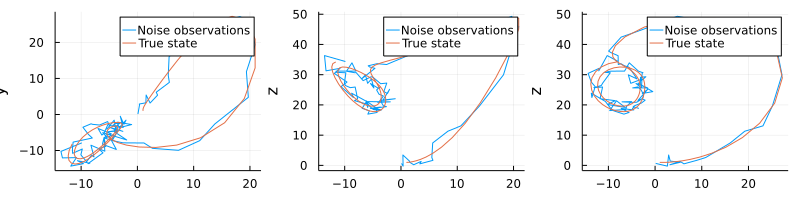

In [27]:
one_nonoise=noise_free_trainset[1]
one=trainset[1]

gx, gy, gz = zeros(100), zeros(100), zeros(100)
rx, ry, rz = zeros(100), zeros(100), zeros(100)

for i=1:100
    rx[i], ry[i], rz[i] = one[i][1], one[i][2], one[i][3]
    gx[i], gy[i], gz[i] = one_nonoise[i][1], one_nonoise[i][2], one_nonoise[i][3]

end
p1=plot(rx,ry,label="Noise observations")
p1=plot!(gx,gy,label="True state")
xlabel!("x")
ylabel!("y")

p2=plot(rx,rz,label="Noise observations")
p2=plot!(gx,gz,label="True state")
xlabel!("x")
ylabel!("z")

p3=plot(ry,rz,label="Noise observations")
p3=plot!(gy,gz,label="True state")
xlabel!("y")
ylabel!("z")

plot(p1, p2, p3, size = (800, 200),layout=(1,3))

### Inference for filtering

Bayesian filtering is considered with state estimation in general probabilistic state space models which have the following form:
$$
x_k \sim p(x_k | x_{k-1}) \\
y_k \sim p(y_k | x_k).
$$
where $x_k \sim p(x_k | x_{k-1})$ is the dynamic model which describes the stochastic dynamics of the system. If the dynamic model is know or explicit, the filtering solutions can be calculated by Chapman–Kolmogorov equation in "Bayesian Filtering and Smoothing". However, for Lorenz system, the dynamic model is nonlinear and hard to descibe. Hence, we develop a neural network to fomulate the dynamics of Lorenz system.
$$
p(x_k | x_{k-1})=\mathcal{N}(x_k | A_{k-1}*x_{k-1}, Q) \\
A_{k-1}=NN(y_{k-1})
$$
where $NN$ is the neural network. The input is the observation $y_{k-1}$, and output is the trasition matrix $A_{k-1}$.

In [28]:
#Neural Network model
mutable struct NN
    InputLayer
    OutputLater
    g
    params

    function NN(W1,b1,W3,b3)
        InputLayer = Dense(W1, b1, relu)
        OutputLayer = Dense(W3, b3)
        g = Chain(InputLayer, OutputLayer);
        new(InputLayer, OutputLayer, g, (W1,b1,W3,b3))
    end
end

We treat trasition matrix $A_{k-1}$ as a datavar in ReactiveMP and develop the following state space model.

In [29]:
#State Space Model
@model function ssm(n, As, Q::ConstVariable, B::ConstVariable, R::ConstVariable)
   
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior_mean = zeros(3)
    x_prior_cov  = Matrix(Diagonal(ones(3)))
    
    x[1] ~ MvNormalMeanCovariance(x_prior_mean, x_prior_cov)
    y[1] ~ MvNormalMeanCovariance(B * x[1], R) where { q = q(mean)q(out)q(cov) }
    
    for i in 2:n
        x[i] ~ MvNormalMeanCovariance(As[i - 1] * x[i - 1], Q) where { q = q(mean, out)q(cov) }
        y[i] ~ MvNormalMeanCovariance(B * x[i], R) where { q = q(mean)q(out)q(cov) }
    end
    
    return x, y
end

We set the Covariance of dynamic model and measurement model as identity matrix. And we define the measurement model as $p(y_k | x_k)=\mathcal{N}(y_k | B*x_k, R)$, where B is the identity matrix.

In [30]:
Q = Matrix(Diagonal(ones(3)))
B = Matrix(Diagonal(ones(3)))
R = Matrix(Diagonal(ones(3)))
;

We can develop *custom_inference* function to infer the hidden state $x_k$, and calculate the Free Energy.

In [31]:
function custom_inference(data, W1,b1,W3,b3)
    n = length(data)
    
    neural = NN(W1,b1,W3,b3)
    Flux.reset!(neural)
    
    # As  = map((d) -> Diagonal(neural.g(d)), data[1:end-1])
    As  = map((d) -> Matrix(Diagonal(neural.g(d))), data[1:end-1])
    
    model, (x, y) = ssm(n, As, Q, B, R)
    
    x_buffer = Vector{Marginal}(undef, n)
    fe_value = nothing
    
    x_subscription = subscribe!(getmarginals(x), (xs) -> copyto!(x_buffer, xs))
    f_subscription = subscribe!(score(BetheFreeEnergy(), model, AsapScheduler()), (fe) -> fe_value = fe)
    
    for i in 1:n
        update!(y[i], data[i])
    end
    
    unsubscribe!(x_subscription)
    unsubscribe!(f_subscription)
    Flux.reset!(neural)
    
    return x_buffer, fe_value
end

custom_inference (generic function with 1 method)

Alternatively, we can choose the *inference* function in the **ReactiveMP.jl**. Before that, we need to bulid a function to get the matrix $A$ output by the neural network. And the $A$ is treated as a datavar in the inference function.

In [32]:
function get_matrix_AS(data, W1,b1,W3,b3)
    n = length(data)
    neural = NN(W1,b1,W3,b3)
    Flux.reset!(neural)
    As  = map((d) -> Matrix(Diagonal(neural.g(d))), data[1:end-1])
    return As
end

get_matrix_AS (generic function with 1 method)

The weights of neural network $NN$ are initialized.

In [33]:
# Initial model parameters
W1, b1 = randn(5,3)./100, randn(5)./100
W3, b3 = randn(3,5)./100, randn(3)./100
;

Before network training, we shown the inference results of hidden states.

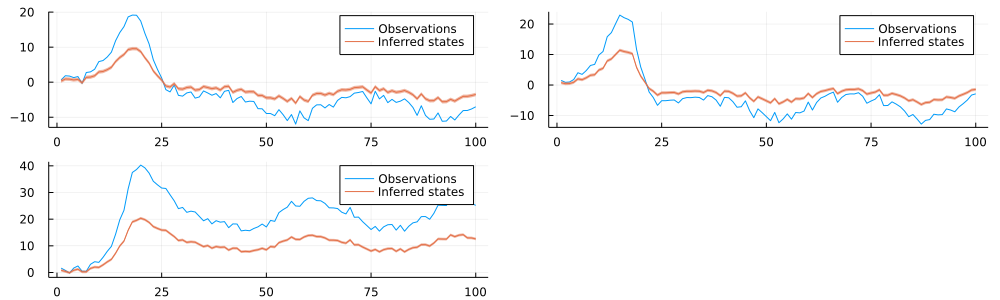

In [34]:
# Performance on an instance from the testset before training
index = 1
data=testset[index]
n=length(data)
result = inference(
    model = Model(ssm, n, get_matrix_AS(data,W1,b1,W3,b3),Q,B,R), 
    data  = (y = data, ), 
    returnvars = (x = KeepLast(), ),
    free_energy = true
)
x_est=result.posteriors[:x]
rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

p1 = plot(rx,label="Observations")
p1 = plot!(rx_est_m,label="Inferred states", ribbon=rx_est_var)

p2 = plot(ry,label="Observations")
p2 = plot!(ry_est_m,label="Inferred states", ribbon=ry_est_var)

p3 = plot(rz,label="Observations")
p3 = plot!(rz_est_m,label="Inferred states", ribbon=rz_est_var)

plot(p1, p2, p3, size = (1000, 300))

### Training network

In this part, we use the Free Energy as the objective function to optimize the weights of network.

In [39]:
# free energy objective to be optimized during training
function fe_tot_est(W1,b1,W3,b3)
    fe_ = 0
    for train_instance in trainset
        result = inference(
            model = Model(ssm, n, get_matrix_AS(train_instance,W1,b1,W3,b3),Q,B,R), 
            data  = (y = train_instance, ), 
            returnvars = (x = KeepLast(), ),
            free_energy = true
        )
        fe_est(W1,b1,W3,b3)=result.free_energy[end]
        fe_ += fe_est(W1,b1,W3,b3)
    end
    return fe_
end

fe_tot_est (generic function with 1 method)

In [44]:
# To track the performance on validation set
function fe_valid_est(W1,b1,W3,b3)
    fe_ = 0
    for valid_instance in validset
        result = inference(
            model = Model(ssm, n, get_matrix_AS(valid_instance,W1,b1,W3,b3),Q,B,R), 
            data  = (y = valid_instance, ), 
            returnvars = (x = KeepLast(), ),
            free_energy = true
        )
        fe_est(W1,b1,W3,b3)=result.free_energy[end]
        fe_ += fe_est(W1,b1,W3,b3)
    end
    return fe_
end

fe_valid_est (generic function with 1 method)

In [45]:
# training
opt = Flux.Optimise.RMSProp(0.01, 0.9)
params = (W1,b1,W3,b3)

for epoch=1:100
    println(epoch)
    grads = ReverseDiff.gradient(fe_tot_est, params);
    for i=1:length(params)
        Flux.Optimise.update!(opt,params[i],grads[i])
    end
    println(fe_valid_est(W1,b1,W3,b3))
end

1
181972.37577311706
2
94826.69439444106
3
47198.04059661787
4
43148.852884859
5
42332.95579096365
6
43899.960426143734
7
50071.424307178866
8
46192.81331522607
9
46828.009226688504
10
38645.574582135705
11
37940.573156990555
12
35000.13834134959
13
34791.29197704279
14
33421.10121203348
15
33664.65684202827
16
32918.724015051914
17
33706.485242227376
18
33175.55708380616
19
34512.358913758275
20
33654.72926615557
21
35075.02962544929
22
33398.84864279699
23
34413.80384989419
24
32359.964353154606
25
33030.67524083689
26
31339.050888888276
27
32049.408983295187
28
30690.77103157227
29
31588.320124842267
30
30380.080264271102
31
31449.228967692732
32
30266.0386503068
33
31420.442094084352
34
30089.634423907795
35
31205.995230278684
36
29822.436485647646
37
30824.701915021968
38
29460.255110222784
39
30410.361864412727
40
29081.955464200597
41
30033.05121356922
42
28728.676230653487
43
29696.666762853514
44
28424.73705927775
45
29438.026802769087
46
28184.608877258266
47
29222.9685271712

With the decrease of free energy, the model has converged. The following figure shows the state estimation results by the trained neural network.

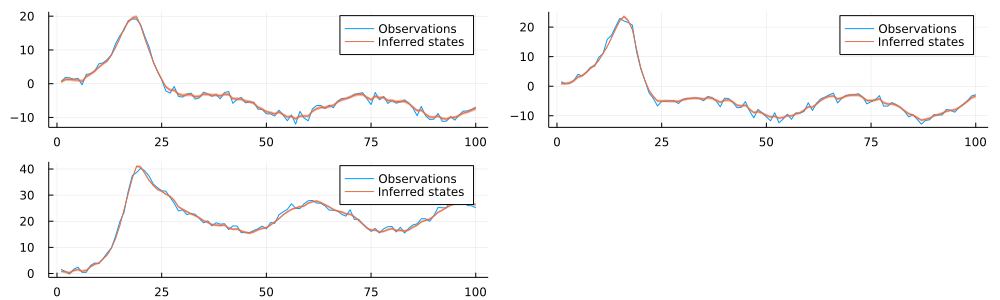

In [46]:
# test after training
index = 1
data=testset[index]
n=length(data)
result = inference(
    model = Model(ssm, n, get_matrix_AS(data,W1,b1,W3,b3),Q,B,R), 
    data  = (y = data, ), 
    returnvars = (x = KeepLast(), ),
    free_energy = true
)
x_est=result.posteriors[:x]

gx, gy, gz = zeros(100), zeros(100), zeros(100)
rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    gx[i], gy[i], gz[i] = noise_free_testset[index][i][1], noise_free_testset[index][i][2], noise_free_testset[index][i][3]
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

# p1 = plot(gx) 
p1 = plot(rx,label="Observations")
p1 = plot!(rx_est_m,label="Inferred states", ribbon=rx_est_var)

p2 = plot(ry,label="Observations")
p2 = plot!(ry_est_m,label="Inferred states", ribbon=ry_est_var)

p3 = plot(rz,label="Observations")
p3 = plot!(rz_est_m,label="Inferred states", ribbon=rz_est_var)

plot(p1, p2, p3, size = (1000, 300))